# 0. Persiapan Awal & Instalasi

In [ ]:
!pip install Sastrawi gensim tensorflow pandas scikit-learn seaborn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 46.9 MB/s eta 0:00:00


# 1. Import Semua Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import os
import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

# Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Gensim
from gensim.models import Word2Vec

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# 2. Download NLTK & Persiapan Awal

In [ ]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 3. Upload File Pendukung

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 4. Definisi Kelas Preprocessor

In [ ]:
class Preprocessor:
    def __init__(self, kamus_path='/content/drive/MyDrive/Skripsi/Data/kamus_slang.json'):
        # Memuat kamus slang
        try:
            with open(kamus_path, 'r') as f:
                self.kamus_slang = json.load(f)
            print("Kamus slang berhasil dimuat.")
        except Exception as e:
            print(f"Error memuat kamus_slang.json: {e}. Lanjutkan dengan kamus kosong.")
            self.kamus_slang = {}

        # 2. Inisialisasi Stopwords
        stopwords_id = set(stopwords.words('indonesian'))
        stopwords_en = set(stopwords.words('english'))
        custom_stopwords = {
            'di', 'ke', 'ya', 'eh', 'he', 'nya', 'nih', 'sih', 'si', 'tau', 'tuh',
            'dong', 'kok', 'wow', 'om', 'kak', 'bang', 'bro', 'cici', 'kakak', 'ka'
        }
        self.list_stopwords_final = stopwords_id.union(stopwords_en).union(custom_stopwords)
        self.list_stopwords_final.discard('tidak')
        self.list_stopwords_final.discard('aku')

        # 3. Inisialisasi Stemmer
        factory = StemmerFactory()
        self.stemmer = factory.create_stemmer()
        print("Preprocessor siap.")

    def cleanse(self, text):
        text = re.sub(r'(@\w+|#\w+|https?://\S+)', '', text)
        text = re.sub(r'(\w)yg', r'\1 yang', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\b([a-zA-Z])\s+(?=[a-zA-Z]\b)', r'\1', text)
        text = re.sub(r'(\w)\1{1,}', r'\1', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def normalize_slang(self, tokens):
        return [self.kamus_slang.get(word, word) for word in tokens]

    def remove_stopwords(self, tokens):
        return [word for word in tokens if word not in self.list_stopwords_final]

    def filter_length(self, tokens):
        return [word for word in tokens if len(word) > 1]

    def stem_tokens(self, tokens):
        if not tokens:
            return []
        return [self.stemmer.stem(word) for word in tokens]

    def preprocess_text(self, text):
        if not isinstance(text, str):
            return []
        text_clean = self.cleanse(text.lower())
        tokens = wordpunct_tokenize(text_clean)
        tokens_normalized = self.normalize_slang(tokens)
        tokens_stopped = self.remove_stopwords(tokens_normalized)
        tokens_filtered = self.filter_length(tokens_stopped)
        tokens_stemmed = self.stem_tokens(tokens_filtered)
        return tokens_stemmed

# 5. Definisi Kelas WordEmbedding

In [ ]:
class WordEmbedding:
    def __init__(self):
        self.word2vec_model = None
        self.config = {
            'max_length': 50,
            'embedding_dim': 300,
            'vocab_size': 10000
        }
        self.tokenizer = Tokenizer(
            num_words=self.config['vocab_size'],
            oov_token="<OOV>"
        )
        print("WordEmbedding siap.")

    def split_and_process_data(self, df_raw, preprocessor):
        print("Membagi data mentah (72% Train, 8% Val, 20% Test)...")
        # 1. Pisahkan 20% Test
        train_val_raw, test_raw = train_test_split(
            df_raw,
            test_size=0.20,
            random_state=42,
            stratify=df_raw['label']
        )

        # 2. Pisahkan 80% sisanya menjadi 72% Train dan 8% Val
        train_raw, val_raw = train_test_split(
            train_val_raw,
            test_size=0.10, # 10% dari 80% = 8%
            random_state=42,
            stratify=train_val_raw['label']
        )

        print(f"Data mentah: Train ({len(train_raw)}), Val ({len(val_raw)}), Test ({len(test_raw)})")

        # 3. Lakukan Preprocessing
        print("Memulai preprocessing Sastrawi pada data Train...")
        X_train_tokens = train_raw['text'].apply(preprocessor.preprocess_text)
        y_train = train_raw['label']

        print("Memulai preprocessing Sastrawi pada data Val...")
        X_val_tokens = val_raw['text'].apply(preprocessor.preprocess_text)
        y_val = val_raw['label']

        print("Memulai preprocessing Sastrawi pada data Test...")
        X_test_tokens = test_raw['text'].apply(preprocessor.preprocess_text)
        y_test = test_raw['label']
        print("Semua data telah diproses.")

        # 4. Melatih Word2Vec & Tokenizer HANYA pada data Train
        print("Melatih model Word2Vec (Skip-gram) pada 72% data train...")
        self.word2vec_model = Word2Vec(
            sentences=X_train_tokens,
            vector_size=self.config['embedding_dim'],
            window=10, min_count=3, sg=1, workers=os.cpu_count()
        )

        print(f"Melatih Tokenizer Keras (dibatasi {self.config['vocab_size']} kata) pada 72% data train...")
        X_train_str = [' '.join(tokens) for tokens in X_train_tokens]
        self.tokenizer.fit_on_texts(X_train_str)

        # 5. Ubah semua set data menjadi sequence
        X_val_str = [' '.join(tokens) for tokens in X_val_tokens]
        X_test_str = [' '.join(tokens) for tokens in X_test_tokens]

        train_seq = self.get_sequences(X_train_str)
        val_seq = self.get_sequences(X_val_str)
        test_seq = self.get_sequences(X_test_str)

        return {
            "train": (train_seq, y_train),
            "val": (val_seq, y_val),
            "test": (test_seq, y_test),
            "val_raw_df": val_raw,
            "test_raw_df": test_raw
        }

    def build_embedding_matrix(self):
        print("Membangun Embedding Matrix ")
        vocab_size = self.config['vocab_size']
        embedding_matrix = np.zeros((vocab_size, self.config['embedding_dim']))

        for word, i in self.tokenizer.word_index.items():
            if i >= vocab_size:
                continue
            if word in self.word2vec_model.wv:
                embedding_matrix[i] = self.word2vec_model.wv[word]
            else:
                # Kata yang tidak ada di Word2Vec diisi random
                embedding_matrix[i] = np.random.normal(scale=0.6, size=(self.config['embedding_dim'],))
        return embedding_matrix

    def get_sequences(self, texts_as_strings):
        seq = self.tokenizer.texts_to_sequences(texts_as_strings)
        return pad_sequences(
            seq,
            maxlen=self.config['max_length'],
            padding='post',
            truncating='post'
        )

    def save_tokenizer(self, filepath):
        print(f"Menyimpan Keras Tokenizer ke {filepath}...")
        tokenizer_json = self.tokenizer.to_json()
        with open(filepath, 'w', encoding='utf-8') as f:
            f.write(json.dumps(tokenizer_json, ensure_ascii=False))

# 6. Definisi Kelas ModelBuilder

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class ModelBuilder:
    def __init__(self, word_embedding):
        self.word_embedding = word_embedding
        self.model = None
        self.config = word_embedding.config

    def build_and_train_model(self, params, train_data, val_data, embedding_matrix):
        print(f"\n--- Memulai Training Skenario (LR={params['learning_rate']}, Batch={params['batch_size']}, Epoch={params['epochs']}) ---")

        self.model = Sequential([
            Embedding(
                input_dim=self.config['vocab_size'],
                output_dim=self.config['embedding_dim'],
                input_length=self.config['max_length'],
                weights=[embedding_matrix],
                trainable=False
            ),
            LSTM(64, dropout=0.2, return_sequences=False),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        self.model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(learning_rate=params['learning_rate']),
            metrics=['accuracy']
        )

        X_train_seq, y_train = train_data
        X_val_seq, y_val = val_data

        history = self.model.fit(
            X_train_seq, y_train,
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            validation_data=(X_val_seq, y_val),
            verbose=1
        )
        print("Training selesai.")
        return history

    def evaluate_model(self, test_data):
        print("Mengevaluasi model menggunakan 20% data test...")
        X_test_seq, y_test = test_data

        y_pred_probs = self.model.predict(X_test_seq)
        y_pred = (y_pred_probs > 0.5).astype(int)

        # Output dict=False untuk string print, dict=True untuk disimpan ke CSV
        report_dict = classification_report(y_test, y_pred, output_dict=True)
        report_str = classification_report(y_test, y_pred, output_dict=False)

        fig, ax = plt.subplots(figsize=(6, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
        ax.set_title('Confusion Matrix (Data Test 20%)')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('Actual Labels')

        print("Evaluasi selesai.")
        return report_str, report_dict, fig

    def plot_history(self, history):
        # Menggunakan subplot 1 baris, 2 kolom
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))

        # --- GRAFIK 1: AKURASI ---
        ax[0].plot(history.history['accuracy'], label='Train Accuracy')
        ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax[0].set_title('Training vs. Validation Accuracy')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Accuracy')
        ax[0].legend()
        ax[0].grid(True) # Tambahkan grid agar mudah dibaca

        # [PENTING] Memaksa sumbu Y mulai dari 0 sampai 1 (100%)
        ax[0].set_ylim(0, 1.05)

        # --- GRAFIK 2: LOSS ---
        ax[1].plot(history.history['loss'], label='Train Loss')
        ax[1].plot(history.history['val_loss'], label='Validation Loss')
        ax[1].set_title('Training vs. Validation Loss')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Loss')
        ax[1].legend()
        ax[1].grid(True) # Tambahkan grid

        # [PENTING] Memaksa sumbu Y Loss mulai dari 0
        ax[1].set_ylim(bottom=0)

        return fig

# 7. Proses Utama

# 7.1. Inisialisasi & Muat Data Mentah

In [ ]:
preprocessor = Preprocessor(kamus_path='/content/drive/MyDrive/Skripsi/Data/kamus_slang.json')
word_embedding = WordEmbedding()
model_builder = ModelBuilder(word_embedding)

NAMA_FILE_DATASET = "/content/drive/MyDrive/Skripsi/Data/dataset_judol_BALANCED_19k.csv"

print(f"Memuat data mentah dari {NAMA_FILE_DATASET}...")
df_raw = pd.read_csv(NAMA_FILE_DATASET)

if 'text' not in df_raw.columns or 'label' not in df_raw.columns:
    print("ERROR: Pastikan file CSV memiliki kolom 'text' dan 'label'.")
else:
    df_raw = df_raw.dropna(subset=['text'])
    print(f"Data mentah berhasil dimuat. Total baris: {len(df_raw)}")
    print(df_raw['label'].value_counts())

Kamus slang berhasil dimuat.
Preprocessor siap.
WordEmbedding siap.
Memuat data mentah dari /content/drive/MyDrive/Skripsi/Data/dataset_judol_BALANCED_19k.csv...
Data mentah berhasil dimuat. Total baris: 19602
label
1    9801
0    9801
Name: count, dtype: int64


# 7.2. Jalankan Pemrosesan Data & Pelatihan Embedding

In [ ]:
data_splits = word_embedding.split_and_process_data(df_raw, preprocessor)

embedding_matrix = word_embedding.build_embedding_matrix()

print(f"Ukuran Data Train: {len(data_splits['train'][0])} (72%)")
print(f"Ukuran Data Val: {len(data_splits['val'][0])} (8%)")
print(f"Ukuran Data Test: {len(data_splits['test'][0])} (20%)")
print(f"Ukuran Embedding Matrix: {embedding_matrix.shape}")

Membagi data mentah (72% Train, 8% Val, 20% Test)...
Data mentah: Train (14112), Val (1569), Test (3921)
Memulai preprocessing Sastrawi pada data Train...
Memulai preprocessing Sastrawi pada data Val...
Memulai preprocessing Sastrawi pada data Test...
Semua data telah diproses.
Melatih model Word2Vec (Skip-gram) pada 72% data train...
Melatih Tokenizer Keras (dibatasi 10000 kata) pada 72% data train...
Membangun Embedding Matrix 
Ukuran Data Train: 14112 (72%)
Ukuran Data Val: 1569 (8%)
Ukuran Data Test: 3921 (20%)
Ukuran Embedding Matrix: (10000, 300)


# 7.2.1 Kamus Token

In [ ]:
word_index = word_embedding.tokenizer.word_index

df_kamus = pd.DataFrame(list(word_index.items()), columns=['Kata', 'Token'])

df_kamus = df_kamus[['Token', 'Kata']]

print(f"Total kata unik (Vocabulary Size) setelah Preprocessing: {len(df_kamus)}")

print("\n--- Tabel IV-13. Kamus Token (Contoh 20 Teratas) ---")
display(df_kamus.head(20))

df_kamus.to_csv("Tabel_IV_13_Kamus_Token.csv", index=False)
print("File 'Tabel_IV_13_Kamus_Token.csv' berhasil disimpan untuk lampiran.")

Total kata unik (Vocabulary Size) setelah Preprocessing: 11257

--- Tabel IV-13. Kamus Token (Contoh 20 Teratas) ---


,Token,Kata
0,1,<OOV>
1,2,tidak
2,3,main
3,4,alexis
4,5,jen
5,6,bikin
6,7,kamar
7,8,mamari
8,9,orang
9,10,langsung


File 'Tabel_IV_13_Kamus_Token.csv' berhasil disimpan untuk lampiran.


# 7.2.2 DEMONSTRASI TAHAPAN PREPROCESSING

In [ ]:
print("Membuat Sampel untuk Tabel IV-6...")

df_judi = df_raw[df_raw['label'] == 1].sample(4, random_state=40)

df_non_judi = df_raw[df_raw['label'] == 0].sample(3, random_state=40)

df_tabel_iv6 = pd.concat([df_judi, df_non_judi]).reset_index(drop=True)

df_tabel_iv6.insert(0, 'No', range(1, len(df_tabel_iv6) + 1))

df_final = df_tabel_iv6[['No', 'text', 'label']].copy()
df_final.columns = ['No', 'Komentar', 'Label']

print("\n--- Tabel IV-6. Contoh Komentar ---")
display(df_final)

nama_file = "Tabel_IV-6_Contoh_Komentar.csv"
df_final.to_csv(nama_file, index=False)
print(f"\n[SUKSES] File '{nama_file}' berhasil disimpan.")

Membuat Sampel untuk Tabel IV-6...

--- Tabel IV-6. Contoh Komentar ---


,No,Komentar,Label
0,1,"Baru seminggu main ALEXIS⭐17⭐, gue udah bisa l...",1
1,2,"Sambil nonton, gua buka ❤ DIORGAMING ❤ , enak ...",1
2,3,"Asli bikin nagih, di 💞 A L E X I S 1 7 💞 sensa...",1
3,4,Nuhun 𝔹 𝕆 𝕎 𝕆 𝟠𝟠! lancar sih 👻,1
4,5,Mentri Keuangan yg sangat dipercaya pak Mulyon...,0
5,6,Kak jen aelopyuuu dewasa bgt ❤,0
6,7,"Peluk mamari, be strong Jennie 😇😇😇😇😇",0



[SUKSES] File 'Tabel_IV-6_Contoh_Komentar.csv' berhasil disimpan.


In [ ]:
# --- 1. Persiapan Sampel Data ---
df_pos = df_raw[df_raw['label'] == 1].sample(4, random_state=40)
df_neg = df_raw[df_raw['label'] == 0].sample(3, random_state=40)

df_sample = pd.concat([df_pos, df_neg]).reset_index(drop=True)
df_sample.insert(0, 'No', range(1, len(df_sample) + 1)) # Menambah kolom No di depan

df_sample = df_sample.rename(columns={'text': 'Komentar', 'label': 'Label'})

print("--- Tabel IV-6. Contoh Komentar (Mentah) ---")
display(df_sample)
df_sample.to_csv("Tabel_IV_6_Sampel_Mentah.csv", index=False)


# --- 2. Tahap Case Folding (Tabel IV-7) ---
df_cf = df_sample.copy()
df_cf['Komentar'] = df_cf['Komentar'].str.lower()

print("\n--- Tabel IV-7. Contoh Hasil Case Folding ---")
display(df_cf)
df_cf.to_csv("Tabel_IV_7_Case_Folding.csv", index=False)


# --- 3. Tahap Cleansing (Tabel IV-8) ---
def demo_cleansing(text):
    text = re.sub(r'(@\w+|#\w+|https?://\S+)', '', text) # Hapus mention/link
    text = re.sub(r'(\w)yg', r'\1 yang', text) # Fix typo umum
    text = re.sub(r'[^a-zA-Z\s]', '', text)   # Hapus angka/simbol
    text = re.sub(r'\b([a-zA-Z])\s+(?=[a-zA-Z]\b)', r'\1', text)

    text = re.sub(r'(\w)\1{1,}', r'\1', text) # Hapus char berulang
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi ganda
    return text

df_cl = df_cf.copy()
df_cl['Komentar'] = df_cl['Komentar'].apply(demo_cleansing)

print("\n--- Tabel IV-8. Contoh Hasil Cleansing (Fixed Spasi) ---")
display(df_cl)
df_cl.to_csv("Tabel_IV_8_Cleansing.csv", index=False)

df_tok = df_cl.copy()
df_tok['Komentar'] = df_tok['Komentar'].apply(wordpunct_tokenize)

print("\n--- Tabel IV-9. Contoh Hasil Tokenizing ---")
display(df_tok)
df_tok.to_csv("Tabel_IV_9_Tokenizing.csv", index=False)


# --- 5. Tahap Normalisasi (Tabel IV-10) ---
df_norm = df_tok.copy()
df_norm['Komentar'] = df_norm['Komentar'].apply(preprocessor.normalize_slang)

print("\n--- Tabel IV-10. Contoh Hasil Normalisasi Teks ---")
display(df_norm)
df_norm.to_csv("Tabel_IV_10_Normalisasi.csv", index=False)


df_stop = df_norm.copy()
def demo_stopwords(tokens):
    tokens = preprocessor.remove_stopwords(tokens)
    tokens = preprocessor.filter_length(tokens)
    return tokens

df_stop['Komentar'] = df_stop['Komentar'].apply(demo_stopwords)

print("\n--- Tabel IV-11. Contoh Hasil Stopwords Removal ---")
display(df_stop)
df_stop.to_csv("Tabel_IV_11_Stopwords_Removal.csv", index=False)


df_stem = df_stop.copy()
df_stem['Komentar'] = df_stem['Komentar'].apply(preprocessor.stem_tokens)

print("\n--- Tabel IV-12. Contoh Hasil Stemming ---")
display(df_stem)
df_stem.to_csv("Tabel_IV_12_Stemming.csv", index=False)

print("\n[INFO] Semua file CSV untuk tabel IV-7 s.d IV-12 telah diperbarui!")

--- Tabel IV-6. Contoh Komentar (Mentah) ---


,No,Komentar,Label
0,1,"Baru seminggu main ALEXIS⭐17⭐, gue udah bisa l...",1
1,2,"Sambil nonton, gua buka ❤ DIORGAMING ❤ , enak ...",1
2,3,"Asli bikin nagih, di 💞 A L E X I S 1 7 💞 sensa...",1
3,4,Nuhun 𝔹 𝕆 𝕎 𝕆 𝟠𝟠! lancar sih 👻,1
4,5,Mentri Keuangan yg sangat dipercaya pak Mulyon...,0
5,6,Kak jen aelopyuuu dewasa bgt ❤,0
6,7,"Peluk mamari, be strong Jennie 😇😇😇😇😇",0



--- Tabel IV-7. Contoh Hasil Case Folding ---


,No,Komentar,Label
0,1,"baru seminggu main alexis⭐17⭐, gue udah bisa l...",1
1,2,"sambil nonton, gua buka ❤ diorgaming ❤ , enak ...",1
2,3,"asli bikin nagih, di 💞 a l e x i s 1 7 💞 sensa...",1
3,4,nuhun 𝔹 𝕆 𝕎 𝕆 𝟠𝟠! lancar sih 👻,1
4,5,mentri keuangan yg sangat dipercaya pak mulyon...,0
5,6,kak jen aelopyuuu dewasa bgt ❤,0
6,7,"peluk mamari, be strong jennie 😇😇😇😇😇",0



--- Tabel IV-8. Contoh Hasil Cleansing (Fixed Spasi) ---


,No,Komentar,Label
0,1,baru semingu main alexis gue udah bisa lunasi kpr,1
1,2,sambil nonton gua buka diorgaming enak banget ...,1
2,3,asli bikin nagih di alexis sensasi menangnya b...,1
3,4,nuhun lancar sih,1
4,5,mentri keuangan yg sangat dipercaya pak mulyono,0
5,6,kak jen aelopyu dewasa bgt,0
6,7,peluk mamari be strong jenie,0



--- Tabel IV-9. Contoh Hasil Tokenizing ---


,No,Komentar,Label
0,1,"[baru, semingu, main, alexis, gue, udah, bisa,...",1
1,2,"[sambil, nonton, gua, buka, diorgaming, enak, ...",1
2,3,"[asli, bikin, nagih, di, alexis, sensasi, mena...",1
3,4,"[nuhun, lancar, sih]",1
4,5,"[mentri, keuangan, yg, sangat, dipercaya, pak,...",0
5,6,"[kak, jen, aelopyu, dewasa, bgt]",0
6,7,"[peluk, mamari, be, strong, jenie]",0



--- Tabel IV-10. Contoh Hasil Normalisasi Teks ---


,No,Komentar,Label
0,1,"[baru, semingu, main, alexis, saya, sudah, bis...",1
1,2,"[sambil, nonton, saya, buka, diorgaming, enak,...",1
2,3,"[asli, bikin, nagih, di, alexis, sensasi, mena...",1
3,4,"[nuhun, lancar, sih]",1
4,5,"[mentri, keuangan, yang, sangat, dipercaya, pa...",0
5,6,"[kak, jen, aelopyu, dewasa, sangat]",0
6,7,"[peluk, mamari, be, strong, jenie]",0



--- Tabel IV-11. Contoh Hasil Stopwords Removal ---


,No,Komentar,Label
0,1,"[semingu, main, alexis, lunasi, kpr]",1
1,2,"[nonton, buka, diorgaming, enak, hiburan, santai]",1
2,3,"[asli, bikin, nagih, alexis, sensasi, menangny...",1
3,4,"[nuhun, lancar]",1
4,5,"[mentri, keuangan, dipercaya, mulyono]",0
5,6,"[jen, aelopyu, dewasa]",0
6,7,"[peluk, mamari, strong, jenie]",0



--- Tabel IV-12. Contoh Hasil Stemming ---


,No,Komentar,Label
0,1,"[semingu, main, alexis, lunas, kpr]",1
1,2,"[nonton, buka, diorgaming, enak, hibur, santai]",1
2,3,"[asli, bikin, nagih, alexis, sensasi, menang, ...",1
3,4,"[nuhun, lancar]",1
4,5,"[tri, uang, percaya, mulyono]",0
5,6,"[jen, aelopyu, dewasa]",0
6,7,"[peluk, mamari, strong, jenie]",0



[INFO] Semua file CSV untuk tabel IV-7 s.d IV-12 telah diperbarui!


# 7.2.3 Sequence dan Padding

In [ ]:
if word_embedding.tokenizer is None:
    print("⚠️ Harap jalankan Tahap 7.2 (split_and_process_data) terlebih dahulu agar Tokenizer terbentuk!")
else:
    print("✅ Tokenizer siap digunakan.")

    # --- 1. Persiapan Sampel Data (Sama dengan 7.2.2) ---
    df_pos = df_raw[df_raw['label'] == 1].sample(4, random_state=40)
    df_neg = df_raw[df_raw['label'] == 0].sample(3, random_state=40)

    df_sample = pd.concat([df_pos, df_neg]).reset_index(drop=True)
    df_sample.insert(0, 'No', range(1, len(df_sample) + 1)) # Kolom No

    # --- 2. Lakukan Full Preprocessing Dulu (Agar siap di-sequence) ---
    print("Melakukan preprocessing pada sampel data...")

    def get_stemmed_string(text):
        tokens = preprocessor.preprocess_text(text)
        return " ".join(tokens) # Gabung token jadi kalimat (spasi separated)

    df_sample['Komentar_Stemmed'] = df_sample['text'].apply(get_stemmed_string)


    # --- 3. Tahap Sequencing (Tabel IV-14) ---
    sequences = word_embedding.tokenizer.texts_to_sequences(df_sample['Komentar_Stemmed'])

    df_seq = pd.DataFrame({
        'No': df_sample['No'],
        'Komentar': df_sample['Komentar_Stemmed'],
        'Sequence': sequences
    })

    print("\n--- Tabel IV-14. Contoh Hasil Sequences ---")
    display(df_seq)
    df_seq.to_csv("Tabel_IV_14_Sequences.csv", index=False)


    # --- 4. Tahap Padding (Tabel IV-15) ---
    maxlen = word_embedding.config['max_length']
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

    padded_list = padded.tolist()

    df_pad = pd.DataFrame({
        'No': df_sample['No'],
        'Komentar': df_sample['Komentar_Stemmed'],
        'Padding': padded_list
    })

    print(f"\n--- Tabel IV-15. Contoh Hasil Padding (Max Length = {maxlen}) ---")
    display(df_pad)
    df_pad.to_csv("Tabel_IV_15_Padding.csv", index=False)

    print("\n[INFO] File 'Tabel_IV_14_Sequences.csv' dan 'Tabel_IV_15_Padding.csv' berhasil disimpan!")

✅ Tokenizer siap digunakan.
Melakukan preprocessing pada sampel data...

--- Tabel IV-14. Contoh Hasil Sequences ---


,No,Komentar,Sequence
0,1,semingu main alexis lunas kpr,"[735, 3, 4, 900, 6895]"
1,2,nonton buka diorgaming enak hibur santai,"[23, 117, 1073, 169, 221, 323]"
2,3,asli bikin nagih alexis sensasi menang bikin t...,"[53, 6, 114, 4, 116, 22, 6, 71, 500]"
3,4,nuhun lancar,"[1833, 181]"
4,5,tri uang percaya mulyono,"[1009, 155, 97, 1412]"
5,6,jen aelopyu dewasa,"[5, 7099, 127]"
6,7,peluk mamari strong jenie,"[216, 8, 107, 2101]"



--- Tabel IV-15. Contoh Hasil Padding (Max Length = 50) ---


,No,Komentar,Padding
0,1,semingu main alexis lunas kpr,"[735, 3, 4, 900, 6895, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,2,nonton buka diorgaming enak hibur santai,"[23, 117, 1073, 169, 221, 323, 0, 0, 0, 0, 0, ..."
2,3,asli bikin nagih alexis sensasi menang bikin t...,"[53, 6, 114, 4, 116, 22, 6, 71, 500, 0, 0, 0, ..."
3,4,nuhun lancar,"[1833, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,5,tri uang percaya mulyono,"[1009, 155, 97, 1412, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,6,jen aelopyu dewasa,"[5, 7099, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
6,7,peluk mamari strong jenie,"[216, 8, 107, 2101, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."



[INFO] File 'Tabel_IV_14_Sequences.csv' dan 'Tabel_IV_15_Padding.csv' berhasil disimpan!


# 7.3. Training Model

In [ ]:
import time

scenarios_config = [
    {'lr': 0.001, 'bs': 32, 'ep': 5},   # Model 1
    {'lr': 0.001, 'bs': 32, 'ep': 10},  # Model 2
    {'lr': 0.001, 'bs': 32, 'ep': 25},  # Model 3
    {'lr': 0.001, 'bs': 64, 'ep': 5},   # Model 4
    {'lr': 0.001, 'bs': 64, 'ep': 10},  # Model 5
    {'lr': 0.001, 'bs': 64, 'ep': 25},  # Model 6
    {'lr': 0.0001, 'bs': 32, 'ep': 5},  # Model 7
    {'lr': 0.0001, 'bs': 32, 'ep': 10}, # Model 8
    {'lr': 0.0001, 'bs': 32, 'ep': 25}, # Model 9
    {'lr': 0.0001, 'bs': 64, 'ep': 5},  # Model 10
    {'lr': 0.0001, 'bs': 64, 'ep': 10}, # Model 11
    {'lr': 0.0001, 'bs': 64, 'ep': 25}, # Model 12
]

training_results = {}

print(f"--- MEMULAI TRAINING 12 SKENARIO ---\n")
start_total = time.time()

for i, config in enumerate(scenarios_config):
    model_name = f"Model {i+1}"

    params = {
        'learning_rate': config['lr'],
        'batch_size': config['bs'],
        'epochs': config['ep']
    }

    print(f"\n>> Sedang Melatih {model_name}...")
    print(f"   Konfigurasi: LR={config['lr']}, Batch={config['bs']}, Epoch={config['ep']}")

    builder = ModelBuilder(word_embedding)

    history = builder.build_and_train_model(
        params,
        data_splits['train'],
        data_splits['val'],
        embedding_matrix
    )

    training_results[model_name] = {
        'model': builder.model,
        'history': history,
        'builder': builder,
        'config': config
    }

    print(f"   [SELESAI] {model_name} berhasil dilatih.")

end_total = time.time()
print(f"\n=== SEMUA TRAINING SELESAI ===")
print(f"Total Waktu: {(end_total - start_total)/60:.2f} menit")

--- MEMULAI TRAINING 12 SKENARIO ---


>> Sedang Melatih Model 1...
   Konfigurasi: LR=0.001, Batch=32, Epoch=5

--- Memulai Training Skenario (LR=0.001, Batch=32, Epoch=5) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.8139 - loss: 0.4294 - val_accuracy: 0.9044 - val_loss: 0.2512
Epoch 2/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8927 - loss: 0.2658 - val_accuracy: 0.9089 - val_loss: 0.2479
Epoch 3/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9077 - loss: 0.2394 - val_accuracy: 0.9063 - val_loss: 0.2370
Epoch 4/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9140 - loss: 0.2219 - val_accuracy: 0.9133 - val_loss: 0.2331
Epoch 5/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9184 - loss: 0.2115 - val_accuracy: 0.9089 - val_loss: 0.2185
Training selesai.
   [SELESAI] Model 1 berhasil dilatih.

>> Sedang Melatih Model 2...
   Konfigurasi: LR=0.001, Batch=32, Epoch=10

--- Memulai Training Skenario (LR=0.001, Batch=32, Epoch=10) ---
Epoch 1/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.8076 - loss: 0.3993 - val_accuracy: 0.9044 - val_loss: 0.2399
Epoch 2/10
441/441 ━━━━━━━━

# 7.4 Evaluasi Model (Grafik, CM, Report & Save)

In [ ]:
summary_data = []

print("--- MEMULAI EVALUASI & PENYIMPANAN ARTEFAK ---\n")

for model_name, data in training_results.items():
    print(f"Processing: {model_name}...")

    model = data['model']
    history = data['history']
    builder = data['builder']
    config = data['config']

    # --- 1. Simpan Model (.h5) ---
    filename_model = f"{model_name}.h5"
    model.save(filename_model)

    # --- 2. Plot & Simpan Grafik History ---
    fig_hist = builder.plot_history(history)
    filename_grafik = f"{model_name} grafik.png"
    fig_hist.savefig(filename_grafik, dpi=300, bbox_inches='tight')
    plt.close(fig_hist) # Tutup plot agar tidak menumpuk di memori

    # --- 3. Evaluasi Data Test (Classification Report & CM) ---
    report_str, report_dict, fig_cm = builder.evaluate_model(data_splits['test'])

    filename_cm = f"{model_name} confusion matrix.png"
    fig_cm.savefig(filename_cm, dpi=300, bbox_inches='tight')
    plt.close(fig_cm)

    # --- 4. Buat Tabel Laporan Per Model (CSV) ---
    metrics_data = {
        "Kategori": ["Non-Judi (0)", "Judi Online (1)", "Rata-rata (Macro Avg)"],
        "Precision": [
            report_dict['0']['precision'],
            report_dict['1']['precision'],
            report_dict['macro avg']['precision']
        ],
        "Recall": [
            report_dict['0']['recall'],
            report_dict['1']['recall'],
            report_dict['macro avg']['recall']
        ],
        "F1-Score": [
            report_dict['0']['f1-score'],
            report_dict['1']['f1-score'],
            report_dict['macro avg']['f1-score']
        ]
    }

    df_metrics = pd.DataFrame(metrics_data)
    df_metrics['Accuracy'] = report_dict['accuracy']

    filename_csv = f"{model_name} classification report.csv"
    df_metrics.to_csv(filename_csv, index=False)

    # --- 5. Masukkan ke Rangkuman Global (Untuk Analisis Bab V) ---
    summary_data.append({
        'Skenario': model_name,
        'LR': config['lr'],
        'Batch': config['bs'],
        'Epoch': config['ep'],
        'Accuracy': report_dict['accuracy'],
        'Precision': report_dict['macro avg']['precision'],
        'Recall': report_dict['macro avg']['recall'],
        'F1-Score': report_dict['macro avg']['f1-score']
    })

# --- 6. Membuat & Menampilkan Tabel Rangkuman Akhir (Tabel V-13) ---
df_summary = pd.DataFrame(summary_data)
df_summary_sorted = df_summary.sort_values(by='F1-Score', ascending=False)

print("\n\n=== TABEL RANGKUMAN HASIL PENELITIAN (Seluruh Skenario) ===")
display(df_summary_sorted)

# Simpan Tabel Rangkuman
df_summary_sorted.to_csv("Tabel_V_13_Rangkuman_Hasil.csv", index=False)
print("\n[INFO] Evaluasi Selesai. Semua file (h5, png, csv) telah dibuat.")

--- MEMULAI EVALUASI & PENYIMPANAN ARTEFAK ---

Processing: Model 1...
Mengevaluasi model menggunakan 20% data test...
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Evaluasi selesai.


Processing: Model 2...
Mengevaluasi model menggunakan 20% data test...
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Evaluasi selesai.


Processing: Model 3...
Mengevaluasi model menggunakan 20% data test...
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
Evaluasi selesai.


Processing: Model 4...
Mengevaluasi model menggunakan 20% data test...
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Evaluasi selesai.


Processing: Model 5...
Mengevaluasi model menggunakan 20% data test...
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Evaluasi selesai.


Processing: Model 6...
Mengevaluasi model menggunakan 20% data test...
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
Evaluasi selesai.


Processing: Model 7...
Mengevaluasi model menggunakan 20% data test...
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Evaluasi selesai.


Processing: Model 8...
Mengevaluasi model menggunakan 20% data test...
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Evaluasi selesai.


Processing: Model 9...
Mengevaluasi model menggunakan 20% data test...
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Evaluasi selesai.


Processing: Model 10...
Mengevaluasi model menggunakan 20% data test...
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Evaluasi selesai.


Processing: Model 11...
Mengevaluasi model menggunakan 20% data test...
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Evaluasi selesai.


Processing: Model 12...
Mengevaluasi model menggunakan 20% data test...
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Evaluasi selesai.


=== TABEL RANGKUMAN HASIL PENELITIAN (Seluruh Skenario) ===


,Skenario,LR,Batch,Epoch,Accuracy,Precision,Recall,F1-Score
2,Model 3,0.0010,32,25,0.925529,0.926015,0.925525,0.925507
1,Model 2,0.0010,32,10,0.921959,0.922034,0.921957,0.921955
4,Model 5,0.0010,64,10,0.921194,0.921504,0.921190,0.921179
11,Model 12,0.0001,64,25,0.920428,0.921205,0.920423,0.920391
7,Model 8,0.0001,32,10,0.918133,0.918133,0.918133,0.918133
8,Model 9,0.0001,32,25,0.918133,0.919341,0.918126,0.918073
5,Model 6,0.0010,64,25,0.915583,0.918069,0.915573,0.915456
0,Model 1,0.0010,32,5,0.913798,0.913951,0.913800,0.913790
3,Model 4,0.0010,64,5,0.909972,0.910321,0.909968,0.909952
10,Model 11,0.0001,64,10,0.906401,0.910141,0.906389,0.906186



[INFO] Evaluasi Selesai. Semua file (h5, png, csv) telah dibuat.


# 7.5 Simpan & Download Artefak (ZIP)

In [ ]:
# 1. Simpan Tokenizer
word_embedding.save_tokenizer("tokenizer.json")

# 2. Simpan Data Mentah Validasi
data_splits['val_raw_df'].to_csv("data_validasi_mentah.csv", index=False)
data_splits['test_raw_df'].to_csv("data_uji_mentah.csv", index=False)

# 3. Zip
print("Membuat file ZIP...")
!zip -r hasil_skripsi_akbar.zip *.h5 *.png *.csv *.json

# 4. Download Otomatis
print("Mendownload file ZIP...")
files.download("hasil_skripsi_akbar.zip")

print("\n[SUKSES] Download dimulai. Silakan cek folder download kamu.")

Menyimpan Keras Tokenizer ke tokenizer.json...
Membuat file ZIP...
  adding: Model 10.h5 (deflated 7%)
  adding: Model 11.h5 (deflated 7%)
  adding: Model 12.h5 (deflated 7%)
  adding: Model 1.h5 (deflated 7%)
  adding: Model 2.h5 (deflated 7%)
  adding: Model 3.h5 (deflated 7%)
  adding: Model 4.h5 (deflated 7%)
  adding: Model 5.h5 (deflated 7%)
  adding: Model 6.h5 (deflated 7%)
  adding: Model 7.h5 (deflated 7%)
  adding: Model 8.h5 (deflated 7%)
  adding: Model 9.h5 (deflated 7%)
  adding: e326cd00-7b29-42e9-a936-0485f1747dac.png (deflated 17%)
  adding: Gambar_V_25_Recall_Macro.png (deflated 32%)
  adding: Gambar_V_26_Accuracy.png (deflated 32%)
  adding: Gambar_V_27_F1Score.png (deflated 32%)
  adding: Gambar_V_28_Precision.png (deflated 32%)
  adding: Model 10 confusion matrix.png (deflated 18%)
  adding: Model 10 grafik.png (deflated 17%)
  adding: Model 11 confusion matrix.png (deflated 18%)
  adding: Model 11 grafik.png (deflated 16%)
  adding: Model 12 confusion matrix.png 

NameError: name 'files' is not defined


--- Membuat Gambar V-25 (Recall Macro) ---


/tmp/ipython-input-739620128.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Skenario', y=metric_name, data=df_results, palette=colors)


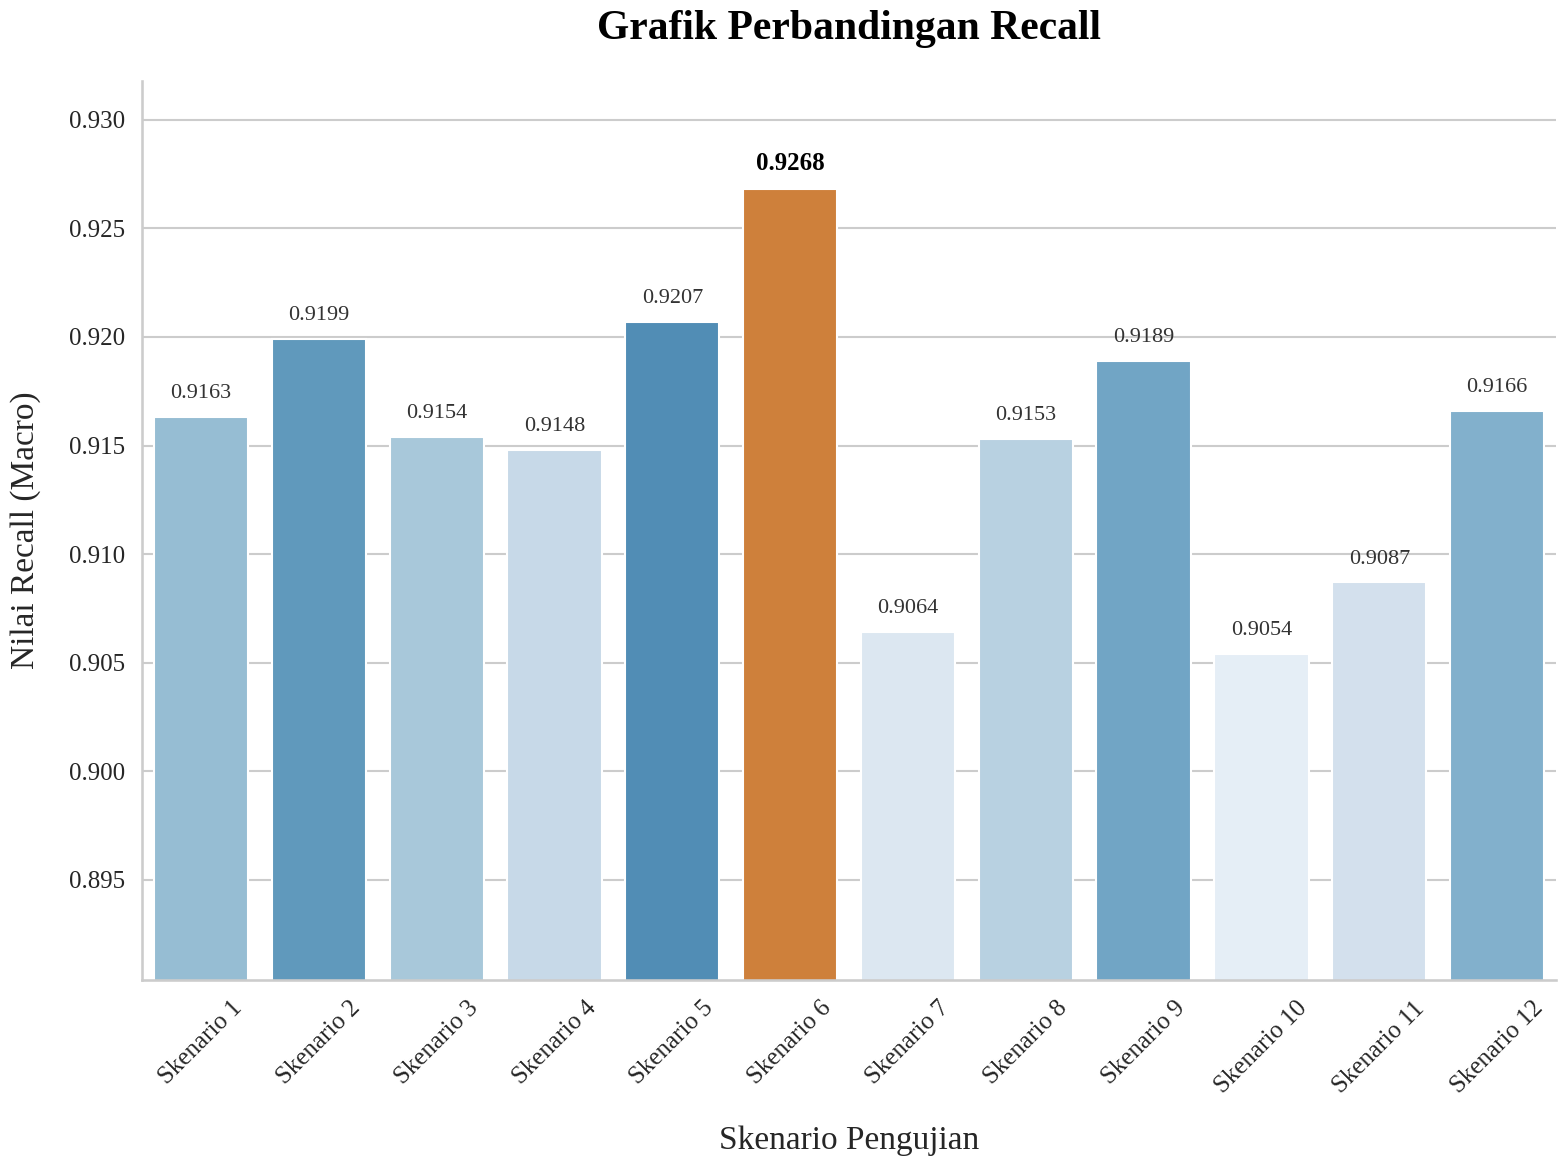


--- Membuat Gambar V-26 (Accuracy) ---


/tmp/ipython-input-739620128.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Skenario', y=metric_name, data=df_results, palette=colors)


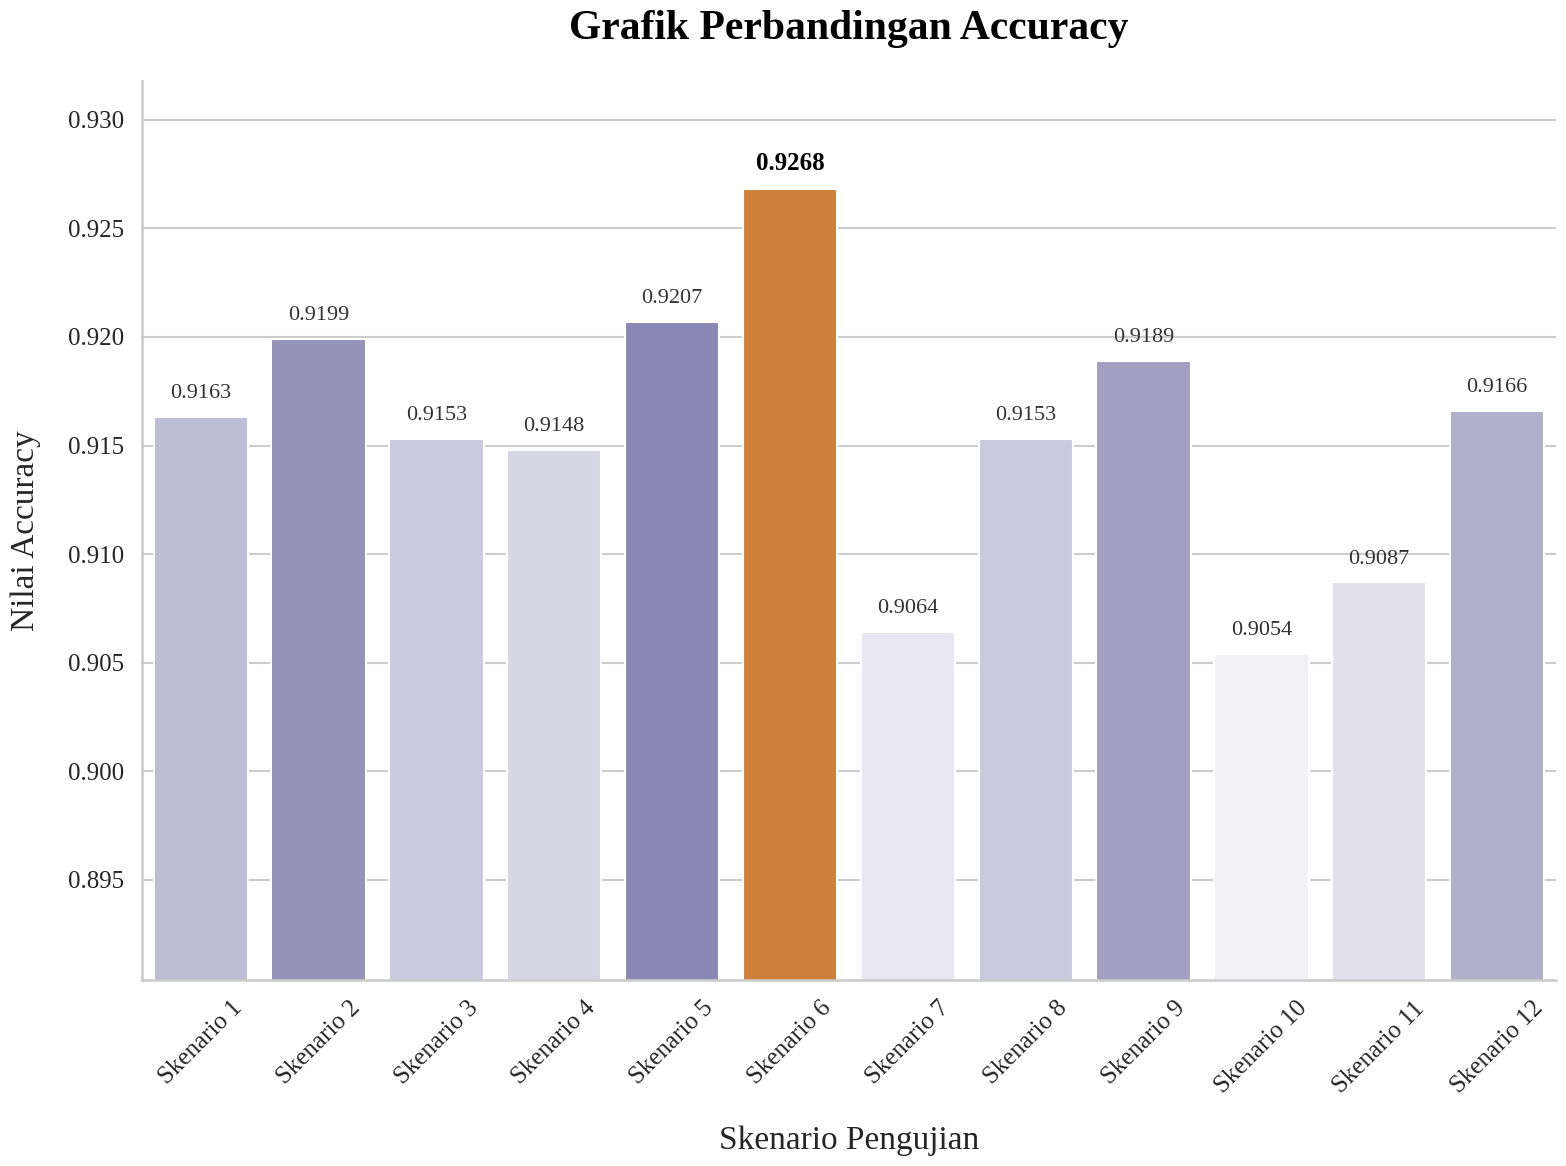


--- Membuat Gambar V-27 (F1-Score) ---


/tmp/ipython-input-739620128.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Skenario', y=metric_name, data=df_results, palette=colors)


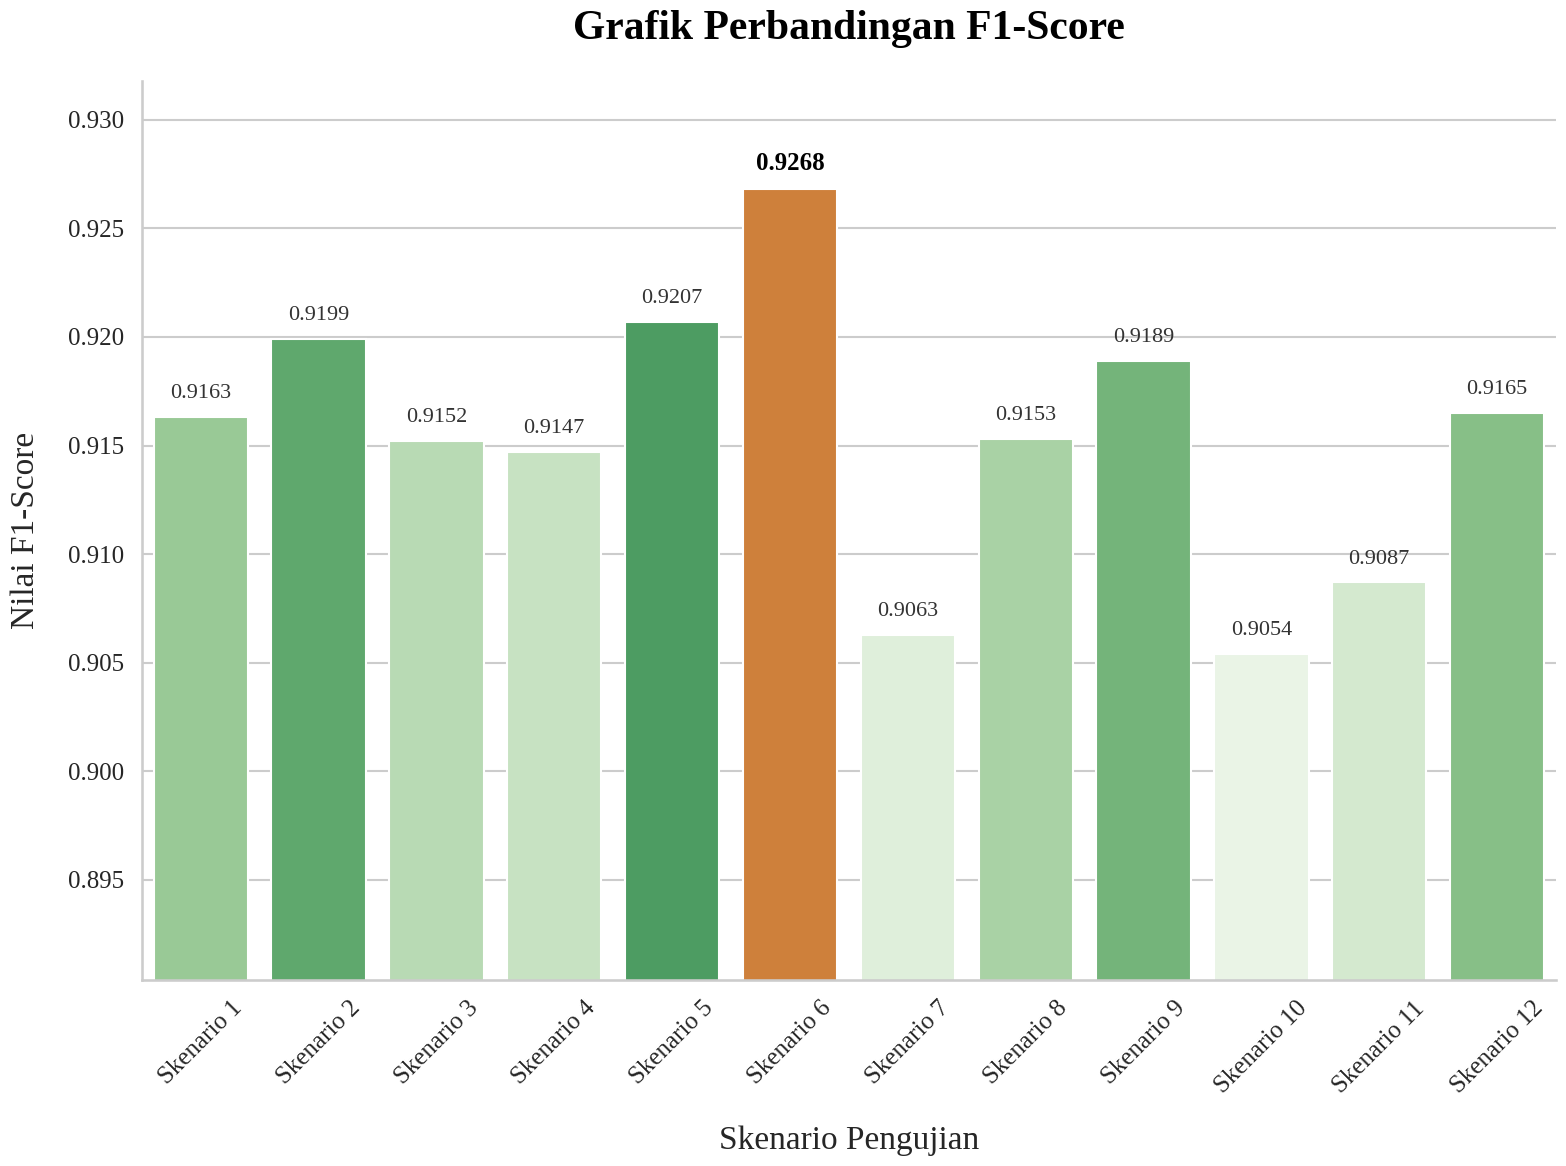


--- Membuat Gambar V-28 (Precision) ---


/tmp/ipython-input-739620128.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Skenario', y=metric_name, data=df_results, palette=colors)


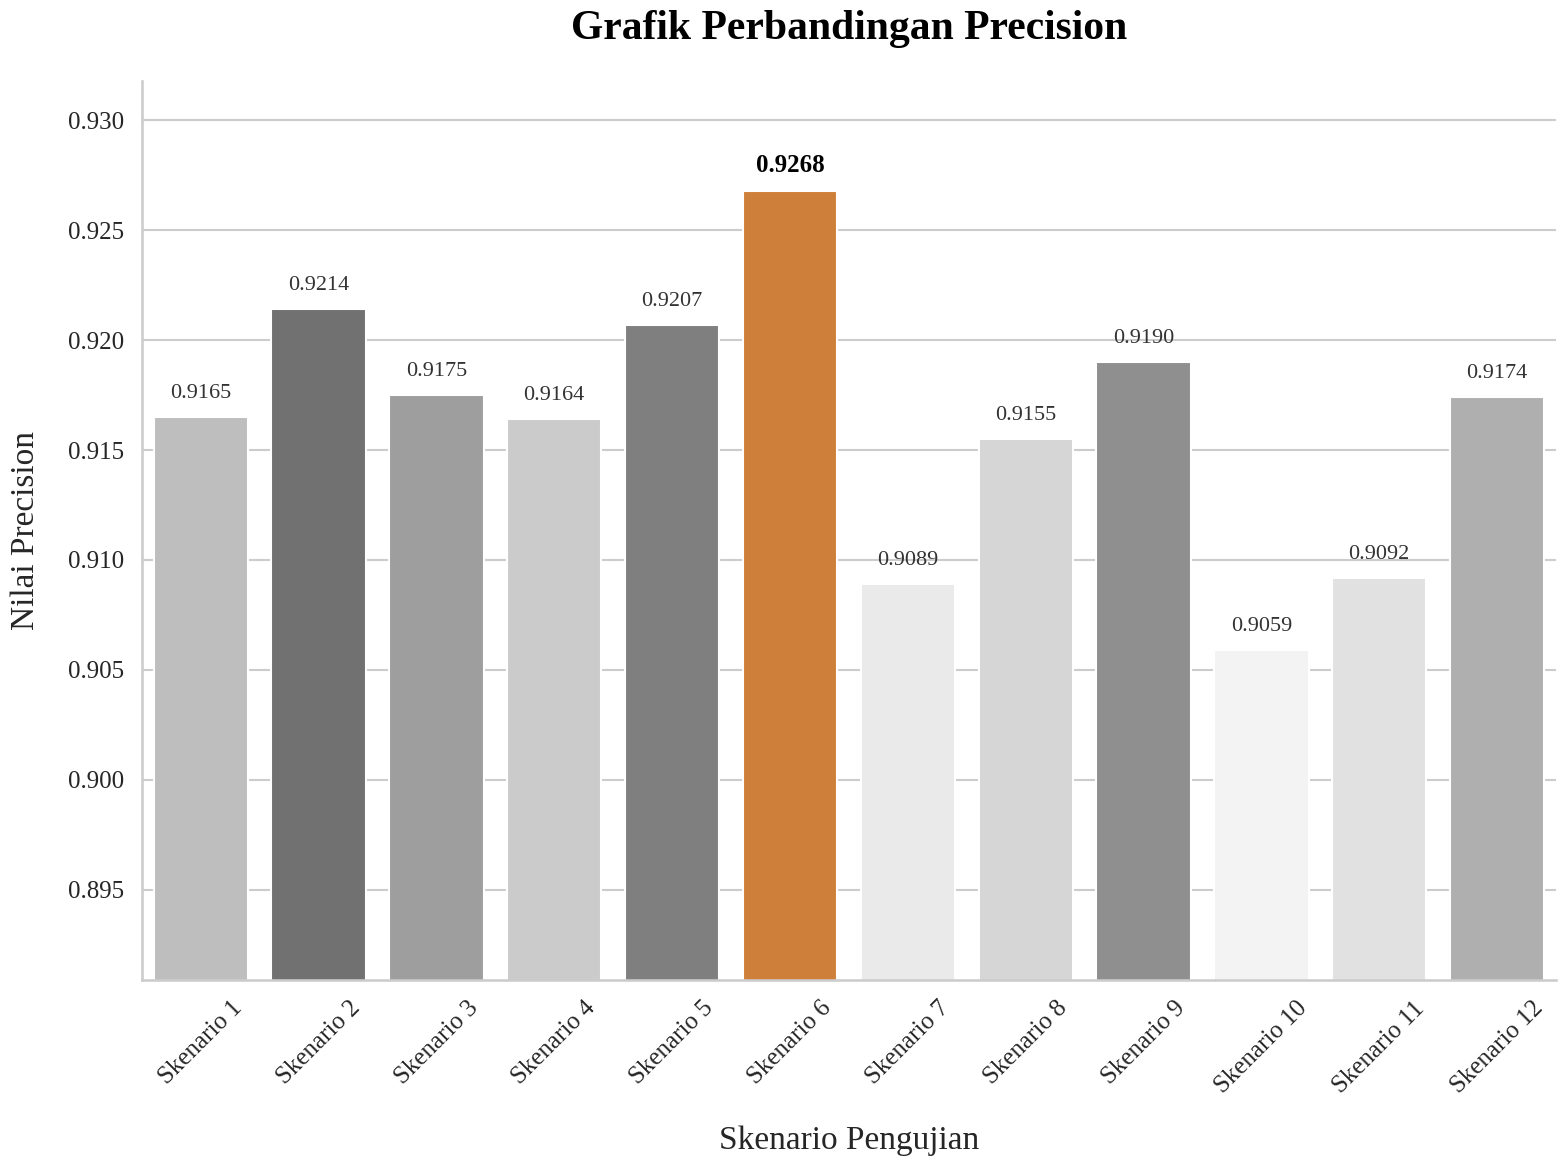


--- Tabel V-13 Rangkuman Hasil Pengujian (Diurutkan berdasarkan Accuracy) ---


,Skenario,Konfigurasi,Accuracy,Precision,Recall,F1-Score
5,Skenario 6,"LR=0.001, B=64, E=25",0.9268,0.9268,0.9268,0.9268
4,Skenario 5,"LR=0.001, B=64, E=10",0.9207,0.9207,0.9207,0.9207
1,Skenario 2,"LR=0.001, B=32, E=10",0.9199,0.9214,0.9199,0.9199
8,Skenario 9,"LR=0.0001, B=32, E=25",0.9189,0.9190,0.9189,0.9189
11,Skenario 12,"LR=0.0001, B=64, E=25",0.9166,0.9174,0.9166,0.9165
0,Skenario 1,"LR=0.001, B=32, E=5",0.9163,0.9165,0.9163,0.9163
7,Skenario 8,"LR=0.0001, B=32, E=10",0.9153,0.9155,0.9153,0.9153
2,Skenario 3,"LR=0.001, B=32, E=25",0.9153,0.9175,0.9154,0.9152
3,Skenario 4,"LR=0.001, B=64, E=5",0.9148,0.9164,0.9148,0.9147
10,Skenario 11,"LR=0.0001, B=64, E=10",0.9087,0.9092,0.9087,0.9087


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd
import numpy as np
import os

if not os.path.exists('Tinos-Regular.ttf'):
    !wget -q -O Tinos-Regular.ttf https://github.com/google/fonts/raw/main/apache/tinos/Tinos-Regular.ttf
if not os.path.exists('Tinos-Bold.ttf'):
    !wget -q -O Tinos-Bold.ttf https://github.com/google/fonts/raw/main/apache/tinos/Tinos-Bold.ttf

try:
    fm.fontManager.addfont('Tinos-Regular.ttf')
    fm.fontManager.addfont('Tinos-Bold.ttf')
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Tinos']
except:
    print("Font Tinos tidak ditemukan, menggunakan default serif.")
    plt.rcParams['font.family'] = 'serif'

# --- 1. DATA HASIL PENELITIAN (MACRO AVERAGE) ---
data = {
    'Skenario': [f'Skenario {i}' for i in range(1, 13)],
    'Accuracy':  [0.9163, 0.9199, 0.9153, 0.9148, 0.9207, 0.9268, 0.9064, 0.9153, 0.9189, 0.9054, 0.9087, 0.9166],
    'Precision': [0.9165, 0.9214, 0.9175, 0.9164, 0.9207, 0.9268, 0.9089, 0.9155, 0.9190, 0.9059, 0.9092, 0.9174],
    'Recall':    [0.9163, 0.9199, 0.9154, 0.9148, 0.9207, 0.9268, 0.9064, 0.9153, 0.9189, 0.9054, 0.9087, 0.9166],
    'F1-Score':  [0.9163, 0.9199, 0.9152, 0.9147, 0.9207, 0.9268, 0.9063, 0.9153, 0.9189, 0.9054, 0.9087, 0.9165]
}

df_results = pd.DataFrame(data)

# --- 2. FUNGSI PLOTTING DIPERBESAR ---
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Tinos']

def plot_metric_big_tall(metric_name, title, filename, y_label_custom=None, color_palette="ch:s=.25,rot=-.25"):
    # REVISI 1: Ukuran Figure lebih besar dan tinggi
    plt.figure(figsize=(16, 12))

    max_val = df_results[metric_name].max()
    min_val = df_results[metric_name].min()

    rank = df_results[metric_name].rank(method="dense", ascending=True)
    pal = sns.color_palette(color_palette, int(rank.max()) + 6)
    colors = [pal[int(r)] if x != max_val else '#E67E22' for r, x in zip(rank, df_results[metric_name])] # Warna highlight oranye tua

    ax = sns.barplot(x='Skenario', y=metric_name, data=df_results, palette=colors)

    # REVISI 2: Font Anotasi Diperbesar
    for p in ax.patches:
        height = p.get_height()
        is_max = (height == max_val)

        weight = 'bold' if is_max else 'normal'
        color = 'black' if is_max else '#333333'
        size = 18 if is_max else 16  # Font angka di atas batang diperbesar

        ax.annotate(f'{height:.4f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=size, color=color, fontweight=weight)

    # REVISI 3: Font Judul dan Label Diperbesar
    plt.title(title, fontsize=30, fontweight='bold', pad=30, color='black')
    plt.ylabel(y_label_custom if y_label_custom else f'Nilai {metric_name}', fontsize=24, labelpad=20)
    plt.xlabel('Skenario Pengujian', fontsize=24, labelpad=20)

    # REVISI 4: Font Sumbu X dan Y Diperbesar
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(fontsize=18)

    # REVISI 5: Mengatur Limit Y agar batang terlihat TINGGI
    # Kita set batas bawah sedikit di bawah nilai minimum, dan batas atas sedikit di atas nilai maksimum
    # Ini akan "men-zoom" grafik sehingga batang terlihat memenuhi frame
    buffer_down = 0.015
    buffer_up = 0.005
    plt.ylim(min_val - buffer_down, max_val + buffer_up)

    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# --- 3. EKSEKUSI PEMBUATAN GAMBAR ---

# Gambar V-25: Recall (Macro) - Warna Biru
print("\n--- Membuat Gambar V-25 (Recall Macro) ---")
plot_metric_big_tall('Recall',
                     'Grafik Perbandingan Recall',
                     'Gambar_V_25_Recall_Macro.png',
                     y_label_custom='Nilai Recall (Macro)',
                     color_palette="Blues")

# Gambar V-26: Accuracy - Warna Ungu
print("\n--- Membuat Gambar V-26 (Accuracy) ---")
plot_metric_big_tall('Accuracy',
                     'Grafik Perbandingan Accuracy',
                     'Gambar_V_26_Accuracy.png',
                     color_palette="Purples")

# Gambar V-27: F1-Score - Warna Hijau
print("\n--- Membuat Gambar V-27 (F1-Score) ---")
plot_metric_big_tall('F1-Score',
                     'Grafik Perbandingan F1-Score',
                     'Gambar_V_27_F1Score.png',
                     color_palette="Greens")

# Gambar V-28: Precision - Warna Merah
print("\n--- Membuat Gambar V-28 (Precision) ---")
plot_metric_big_tall('Precision',
                     'Grafik Perbandingan Precision',
                     'Gambar_V_28_Precision.png',
                     color_palette="Greys")

# --- 4. DATA UNTUK TABEL V-13 ---
print("\n--- Tabel V-13 Rangkuman Hasil Pengujian (Diurutkan berdasarkan Accuracy) ---")
df_sorted = df_results.sort_values(by=['Accuracy', 'F1-Score'], ascending=False)

configs = {
    'Skenario 1': 'LR=0.001, B=32, E=5',
    'Skenario 2': 'LR=0.001, B=32, E=10',
    'Skenario 3': 'LR=0.001, B=32, E=25',
    'Skenario 4': 'LR=0.001, B=64, E=5',
    'Skenario 5': 'LR=0.001, B=64, E=10',
    'Skenario 6': 'LR=0.001, B=64, E=25',
    'Skenario 7': 'LR=0.0001, B=32, E=5',
    'Skenario 8': 'LR=0.0001, B=32, E=10',
    'Skenario 9': 'LR=0.0001, B=32, E=25',
    'Skenario 10': 'LR=0.0001, B=64, E=5',
    'Skenario 11': 'LR=0.0001, B=64, E=10',
    'Skenario 12': 'LR=0.0001, B=64, E=25'
}
df_sorted['Konfigurasi'] = df_sorted['Skenario'].map(configs)
cols = ['Skenario', 'Konfigurasi', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
df_final = df_sorted[cols]

display(df_final)

revisi



--- Membuat Gambar V-25 (Recall Macro) ---


/tmp/ipython-input-2409137986.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Skenario', y=metric_name, data=df_results, palette=colors)


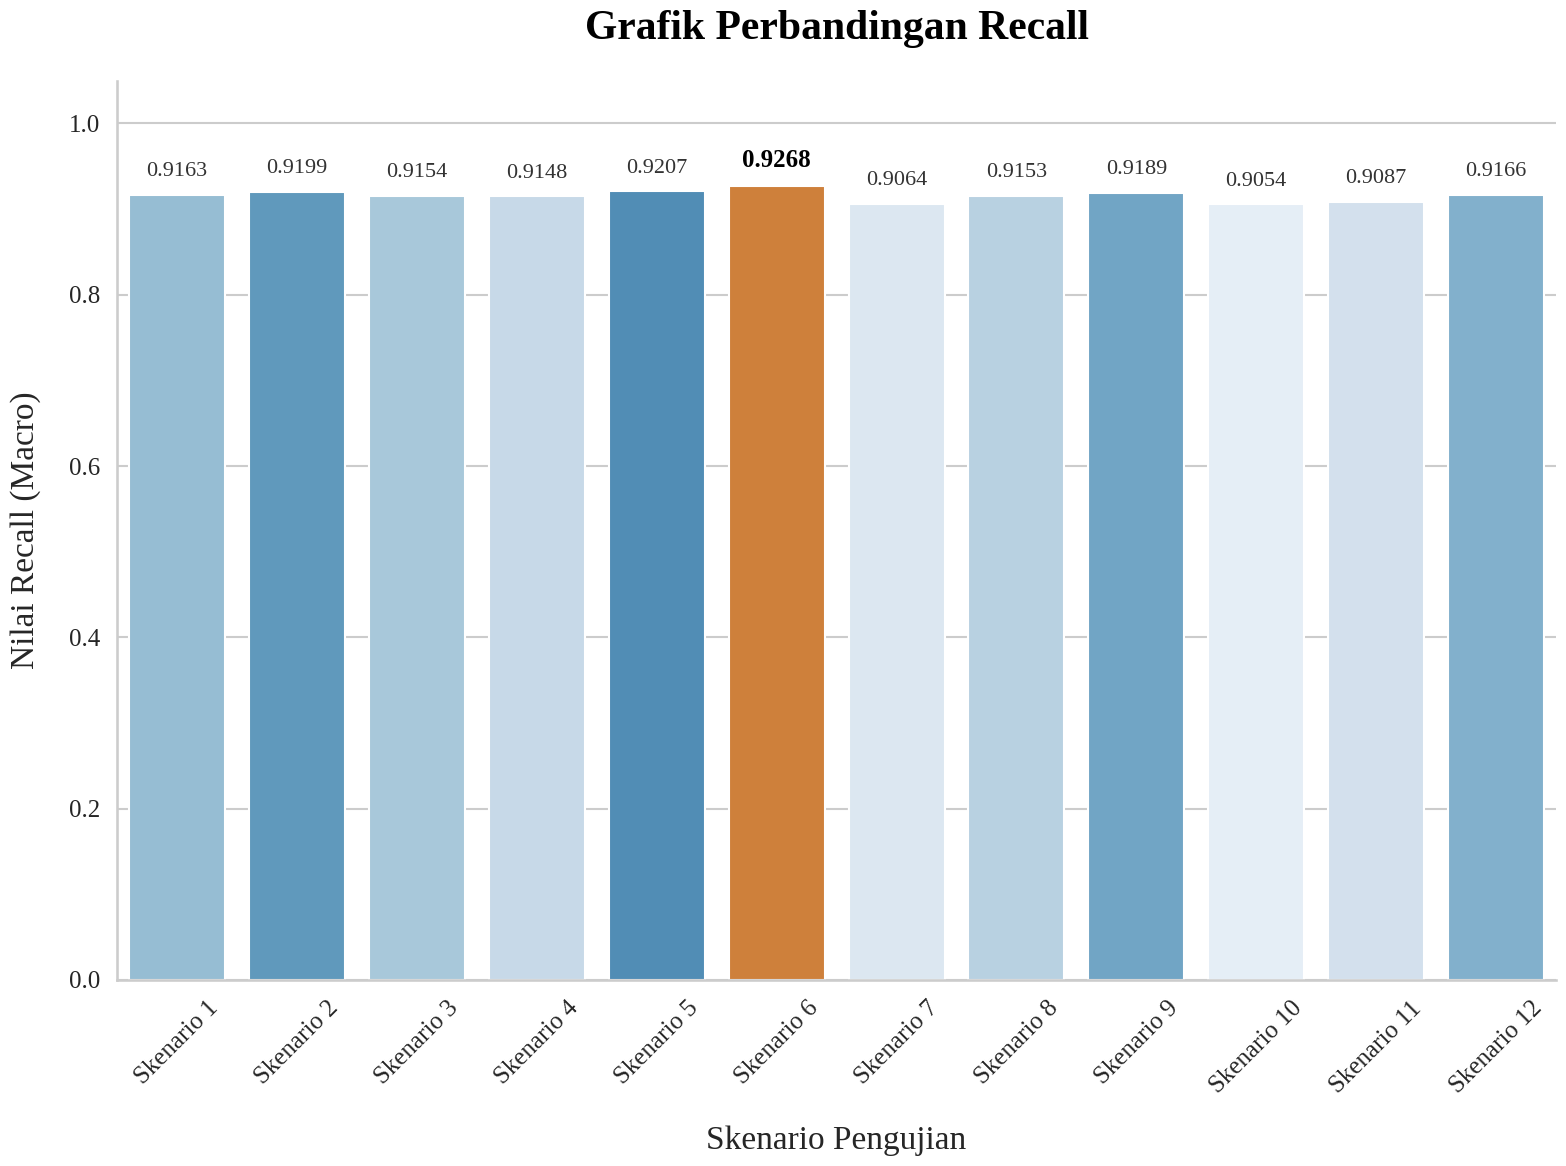


--- Membuat Gambar V-26 (Accuracy) ---


/tmp/ipython-input-2409137986.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Skenario', y=metric_name, data=df_results, palette=colors)


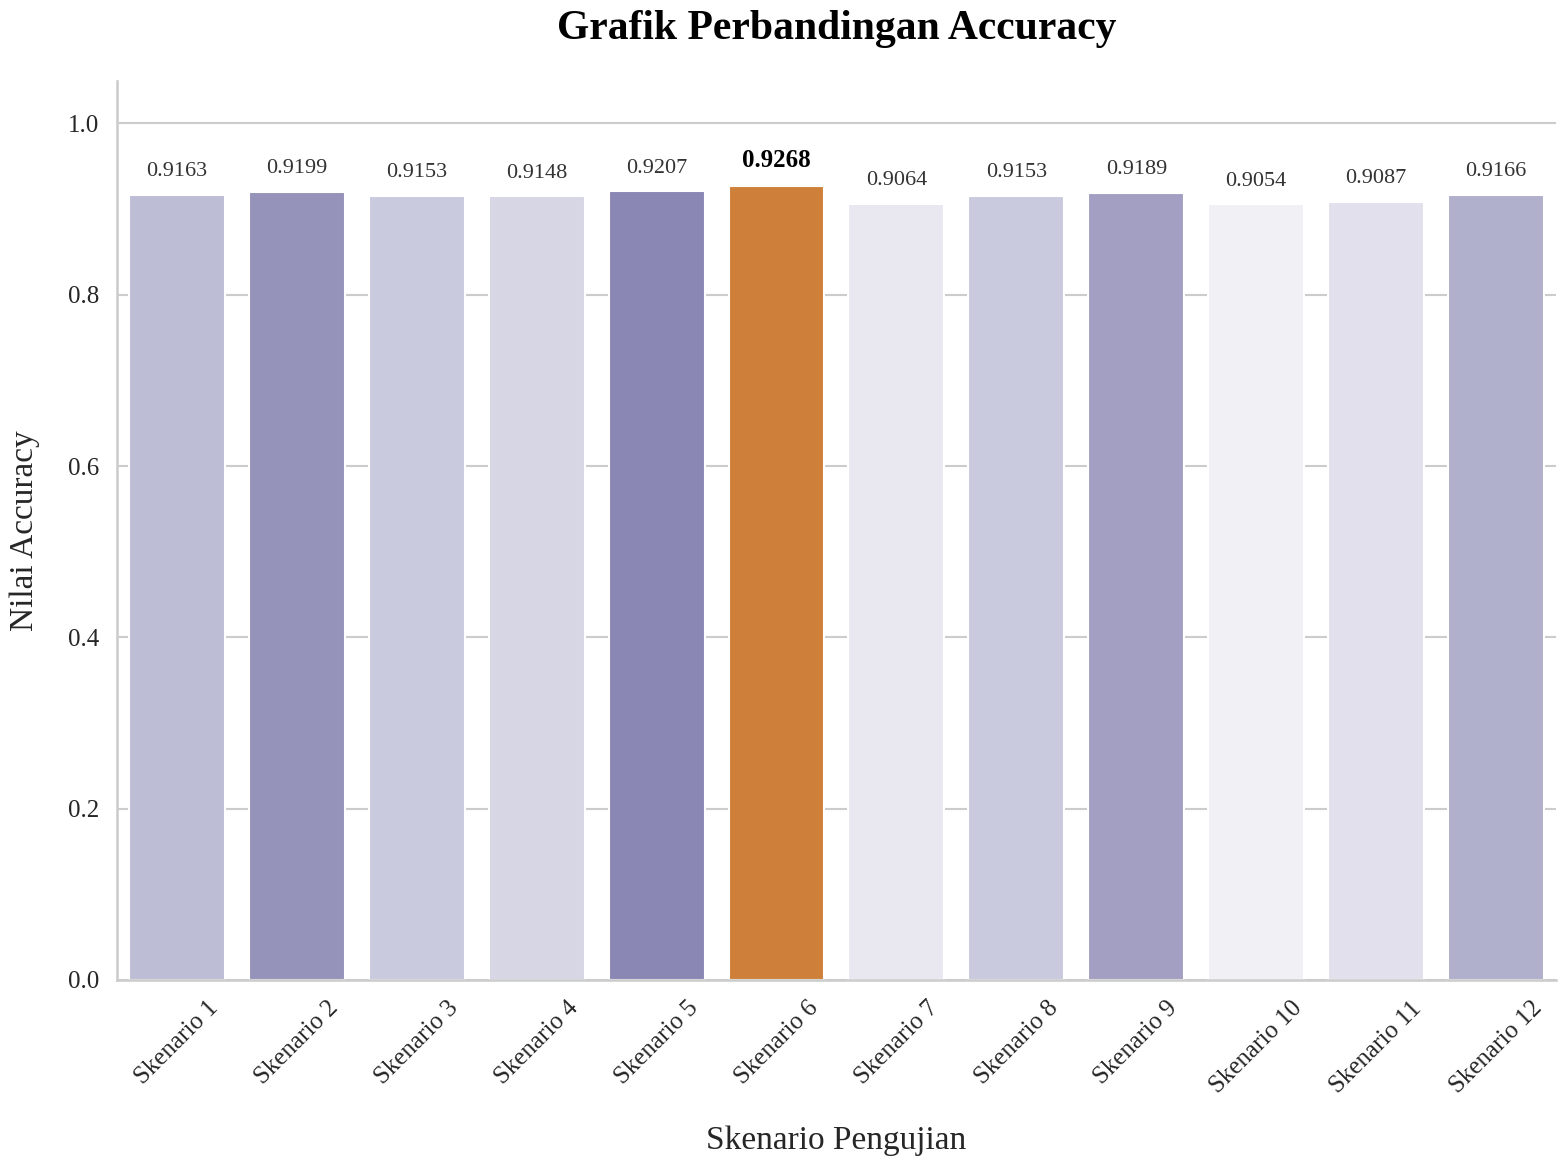


--- Membuat Gambar V-27 (F1-Score) ---


/tmp/ipython-input-2409137986.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Skenario', y=metric_name, data=df_results, palette=colors)


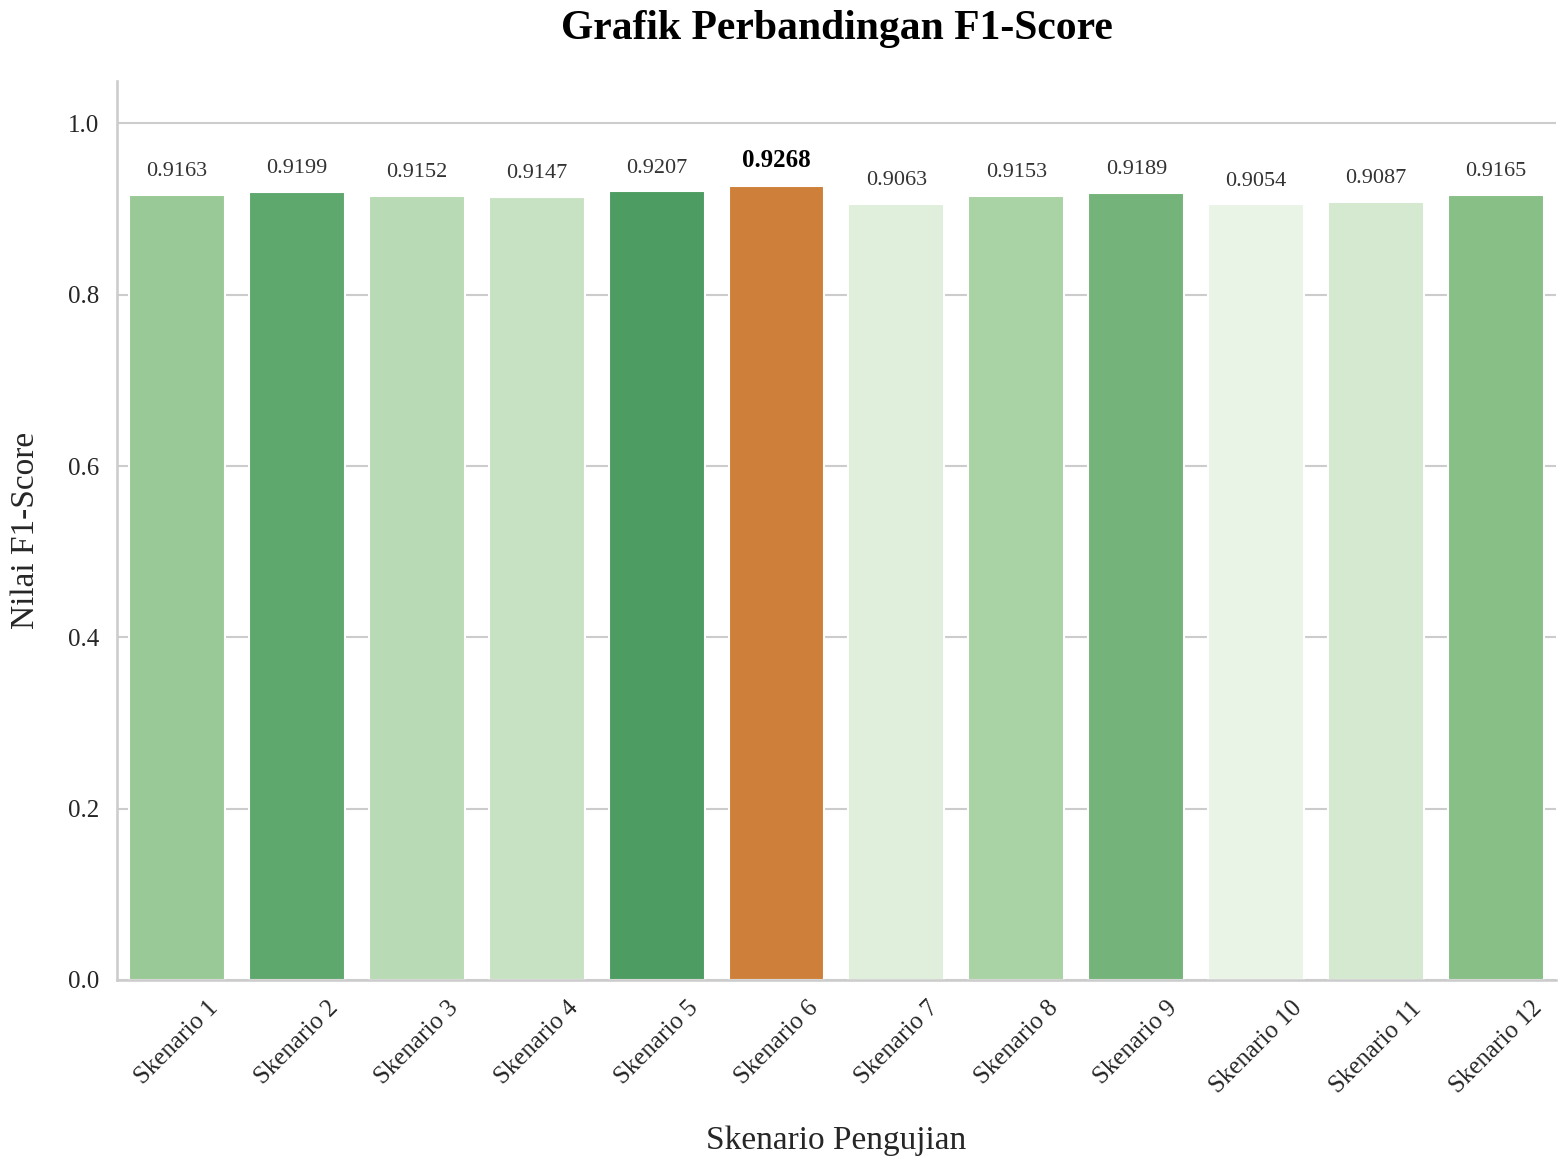


--- Membuat Gambar V-28 (Precision) ---


/tmp/ipython-input-2409137986.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Skenario', y=metric_name, data=df_results, palette=colors)


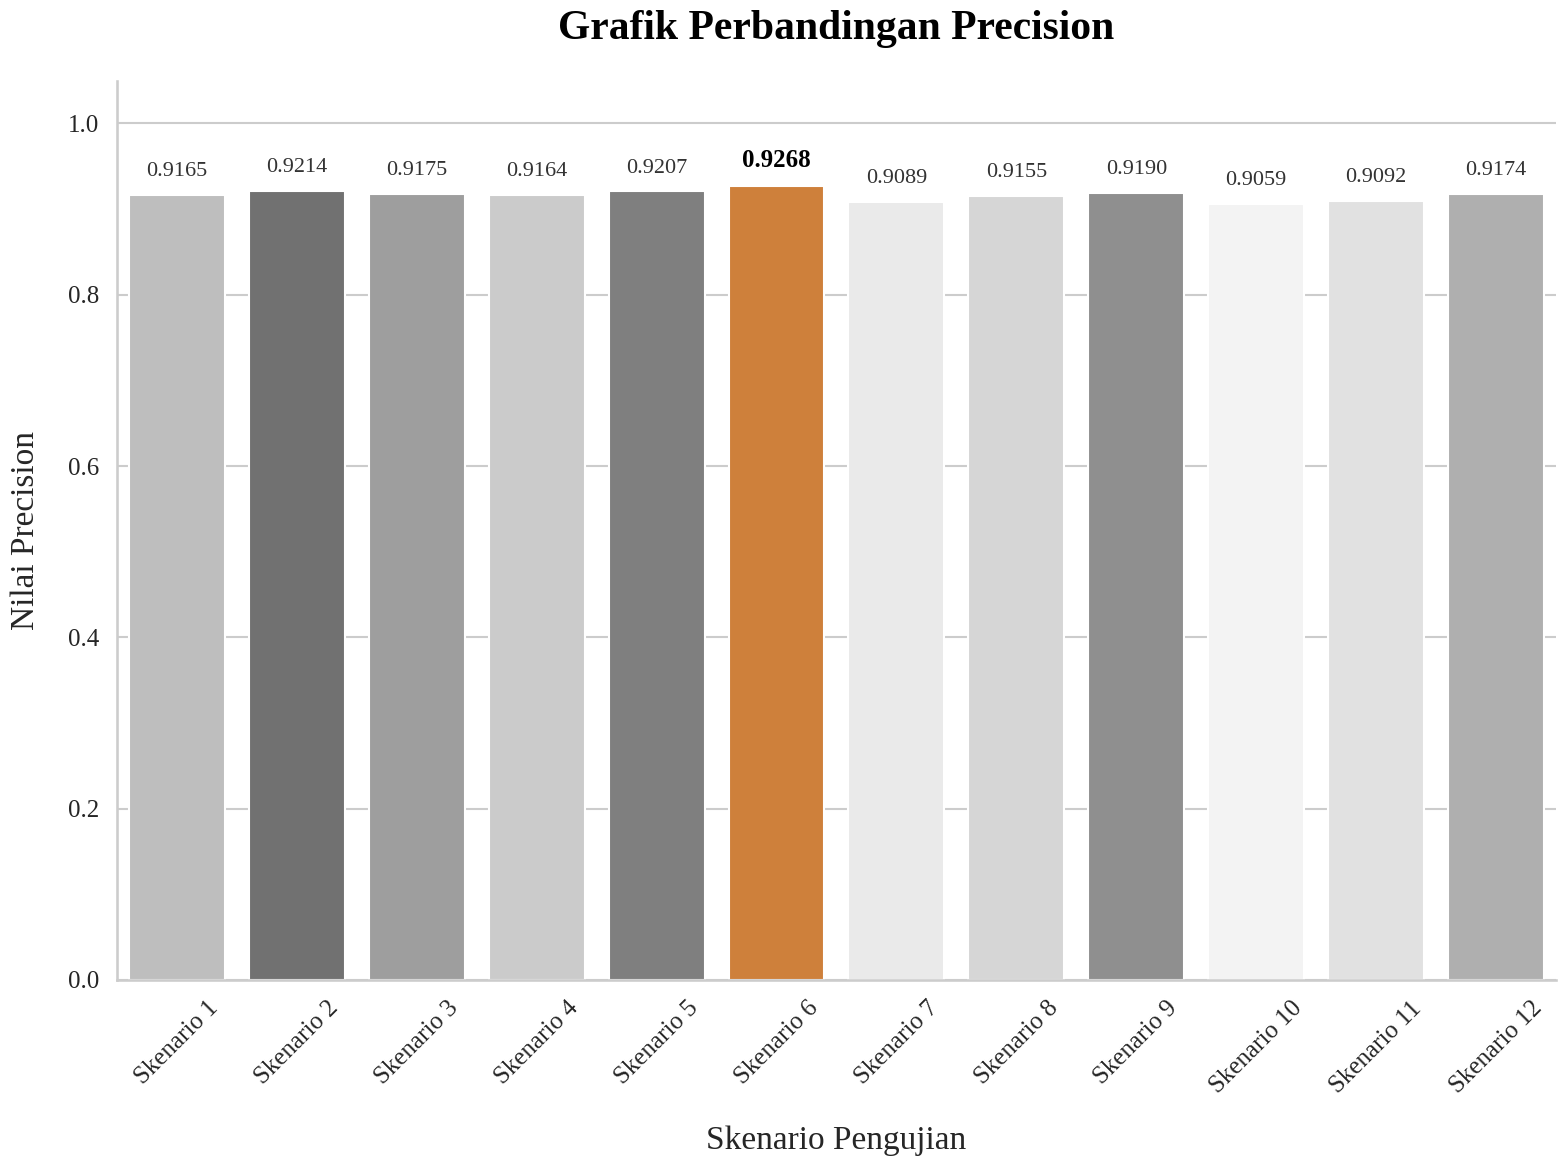


--- Tabel V-13 Rangkuman Hasil Pengujian (Diurutkan berdasarkan Accuracy) ---


,Skenario,Konfigurasi,Accuracy,Precision,Recall,F1-Score
5,Skenario 6,"LR=0.001, B=64, E=25",0.9268,0.9268,0.9268,0.9268
4,Skenario 5,"LR=0.001, B=64, E=10",0.9207,0.9207,0.9207,0.9207
1,Skenario 2,"LR=0.001, B=32, E=10",0.9199,0.9214,0.9199,0.9199
8,Skenario 9,"LR=0.0001, B=32, E=25",0.9189,0.9190,0.9189,0.9189
11,Skenario 12,"LR=0.0001, B=64, E=25",0.9166,0.9174,0.9166,0.9165
0,Skenario 1,"LR=0.001, B=32, E=5",0.9163,0.9165,0.9163,0.9163
7,Skenario 8,"LR=0.0001, B=32, E=10",0.9153,0.9155,0.9153,0.9153
2,Skenario 3,"LR=0.001, B=32, E=25",0.9153,0.9175,0.9154,0.9152
3,Skenario 4,"LR=0.001, B=64, E=5",0.9148,0.9164,0.9148,0.9147
10,Skenario 11,"LR=0.0001, B=64, E=10",0.9087,0.9092,0.9087,0.9087


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd
import numpy as np
import os

# --- Cek dan Install Font (Jika di Google Colab/Environment baru) ---
if not os.path.exists('Tinos-Regular.ttf'):
    !wget -q -O Tinos-Regular.ttf https://github.com/google/fonts/raw/main/apache/tinos/Tinos-Regular.ttf
if not os.path.exists('Tinos-Bold.ttf'):
    !wget -q -O Tinos-Bold.ttf https://github.com/google/fonts/raw/main/apache/tinos/Tinos-Bold.ttf

try:
    fm.fontManager.addfont('Tinos-Regular.ttf')
    fm.fontManager.addfont('Tinos-Bold.ttf')
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Tinos']
except:
    print("Font Tinos tidak ditemukan, menggunakan default serif.")
    plt.rcParams['font.family'] = 'serif'

# --- 1. DATA HASIL PENELITIAN (MACRO AVERAGE) ---
data = {
    'Skenario': [f'Skenario {i}' for i in range(1, 13)],
    'Accuracy':  [0.9163, 0.9199, 0.9153, 0.9148, 0.9207, 0.9268, 0.9064, 0.9153, 0.9189, 0.9054, 0.9087, 0.9166],
    'Precision': [0.9165, 0.9214, 0.9175, 0.9164, 0.9207, 0.9268, 0.9089, 0.9155, 0.9190, 0.9059, 0.9092, 0.9174],
    'Recall':    [0.9163, 0.9199, 0.9154, 0.9148, 0.9207, 0.9268, 0.9064, 0.9153, 0.9189, 0.9054, 0.9087, 0.9166],
    'F1-Score':  [0.9163, 0.9199, 0.9152, 0.9147, 0.9207, 0.9268, 0.9063, 0.9153, 0.9189, 0.9054, 0.9087, 0.9165]
}

df_results = pd.DataFrame(data)

# --- 2. FUNGSI PLOTTING (Skala Y dimulai dari 0) ---
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Tinos']

def plot_metric_big_tall(metric_name, title, filename, y_label_custom=None, color_palette="ch:s=.25,rot=-.25"):
    # Ukuran Figure lebih besar dan tinggi
    plt.figure(figsize=(16, 12))

    max_val = df_results[metric_name].max()

    # Ranking untuk pewarnaan gradasi
    rank = df_results[metric_name].rank(method="dense", ascending=True)
    pal = sns.color_palette(color_palette, int(rank.max()) + 6)
    colors = [pal[int(r)] if x != max_val else '#E67E22' for r, x in zip(rank, df_results[metric_name])]

    ax = sns.barplot(x='Skenario', y=metric_name, data=df_results, palette=colors)

    # Anotasi Angka
    for p in ax.patches:
        height = p.get_height()
        is_max = (height == max_val)

        weight = 'bold' if is_max else 'normal'
        color = 'black' if is_max else '#333333'
        size = 18 if is_max else 16

        ax.annotate(f'{height:.4f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=size, color=color, fontweight=weight)

    # Judul dan Label
    plt.title(title, fontsize=30, fontweight='bold', pad=30, color='black')
    plt.ylabel(y_label_custom if y_label_custom else f'Nilai {metric_name}', fontsize=24, labelpad=20)
    plt.xlabel('Skenario Pengujian', fontsize=24, labelpad=20)

    # Font Sumbu X dan Y
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(fontsize=18)

    # --- REVISI 5 (DIPERBARUI): SKALA DIMULAI DARI 0 ---
    # Kita set batas bawah (bottom) menjadi 0.
    # Batas atas (top) kita set sedikit di atas 1.0 atau nilai max agar terlihat rapi.
    # Karena ini metrik akurasi (0-1), batas atas 1.05 sudah cukup aman untuk ruang teks.
    plt.ylim(0, 1.05)

    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# --- 3. EKSEKUSI PEMBUATAN GAMBAR ---

# Gambar V-25: Recall (Macro) - Warna Biru
print("\n--- Membuat Gambar V-25 (Recall Macro) ---")
plot_metric_big_tall('Recall',
                     'Grafik Perbandingan Recall',
                     'Gambar_V_25_Recall_Macro.png',
                     y_label_custom='Nilai Recall (Macro)',
                     color_palette="Blues")

# Gambar V-26: Accuracy - Warna Ungu
print("\n--- Membuat Gambar V-26 (Accuracy) ---")
plot_metric_big_tall('Accuracy',
                     'Grafik Perbandingan Accuracy',
                     'Gambar_V_26_Accuracy.png',
                     color_palette="Purples")

# Gambar V-27: F1-Score - Warna Hijau
print("\n--- Membuat Gambar V-27 (F1-Score) ---")
plot_metric_big_tall('F1-Score',
                     'Grafik Perbandingan F1-Score',
                     'Gambar_V_27_F1Score.png',
                     color_palette="Greens")

# Gambar V-28: Precision - Warna Merah
print("\n--- Membuat Gambar V-28 (Precision) ---")
plot_metric_big_tall('Precision',
                     'Grafik Perbandingan Precision',
                     'Gambar_V_28_Precision.png',
                     color_palette="Greys")

# --- 4. DATA UNTUK TABEL V-13 ---
print("\n--- Tabel V-13 Rangkuman Hasil Pengujian (Diurutkan berdasarkan Accuracy) ---")
df_sorted = df_results.sort_values(by=['Accuracy', 'F1-Score'], ascending=False)

configs = {
    'Skenario 1': 'LR=0.001, B=32, E=5',
    'Skenario 2': 'LR=0.001, B=32, E=10',
    'Skenario 3': 'LR=0.001, B=32, E=25',
    'Skenario 4': 'LR=0.001, B=64, E=5',
    'Skenario 5': 'LR=0.001, B=64, E=10',
    'Skenario 6': 'LR=0.001, B=64, E=25',
    'Skenario 7': 'LR=0.0001, B=32, E=5',
    'Skenario 8': 'LR=0.0001, B=32, E=10',
    'Skenario 9': 'LR=0.0001, B=32, E=25',
    'Skenario 10': 'LR=0.0001, B=64, E=5',
    'Skenario 11': 'LR=0.0001, B=64, E=10',
    'Skenario 12': 'LR=0.0001, B=64, E=25'
}
df_sorted['Konfigurasi'] = df_sorted['Skenario'].map(configs)
cols = ['Skenario', 'Konfigurasi', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
df_final = df_sorted[cols]

display(df_final)